<a href="https://colab.research.google.com/github/JohnMorrisonn/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS6_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  #Desktop users
  time_on_site = random.uniform(10,600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  #Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=261.8803356719603, mobile=False), User(purchased=True, time_on_site=123.90929531588654, mobile=True), User(purchased=True, time_on_site=157.95800723613576, mobile=True), User(purchased=False, time_on_site=267.268644008997, mobile=True), User(purchased=True, time_on_site=182.09912712140547, mobile=False), User(purchased=False, time_on_site=540.9349811649057, mobile=False), User(purchased=False, time_on_site=239.31211758950266, mobile=True), User(purchased=False, time_on_site=187.74234288931987, mobile=True), User(purchased=True, time_on_site=353.12020800370743, mobile=False), User(purchased=False, time_on_site=244.74252428722104, mobile=True)]


In [0]:
!pip freeze

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,261.880336,False
1,True,123.909295,True
2,True,157.958007,True
3,False,267.268644,True
4,True,182.099127,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.067608030992863,6.322160385636115,6.508221441453129,6.673501247643519,6.893527931727841,7.084094663325335,7.214531314547365,8.48707469453366,8.67648480514533,9.422710186981549,9.98693782458029,10.646353703164959,10.8013329952566,11.231557498816795,11.295034835815269,11.665341860138184,11.853038442676986,11.857801060003764,12.63219158259933,12.69247492938328,13.035815376505472,13.310469980711389,13.704171667725456,14.141414962488158,14.326590136260164,15.296283347996724,15.768040457430034,15.889080870130801,16.118781558267315,16.51461671898165,16.73937014265775,17.45496059434572,17.475066397677843,17.818744594618032,18.102802266808876,18.210663344165177,18.60992310214207,18.97070321907302,19.327065527268694,19.897508369261715,...,517.9889478534913,518.5889151833592,520.5638986204413,521.5573677661655,522.9481316846117,523.0498354082495,523.1776205209319,525.6758912630715,528.057606930296,529.9877560403952,531.0862960483621,531.6556899438044,531.9121961698203,534.5056286429996,537.8585185601216,539.5053569952324,540.9349811649057,543.043214110586,543.6999449862391,549.5693178906738,550.3792032869943,550.498919550925,550.6491878797594,557.3604125313874,558.0854376047374,560.577507385155,566.9451977084849,567.9514277588044,569.3120365771262,571.2884609144322,573.1477478707309,577.0358129100131,578.4858142882822,586.3992374122166,588.9530319614626,591.2043140966571,594.4257407657257,594.6703798897701,597.1729783225798,599.9410866941313
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,0,1,1,1,1,0,1,0,1,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,...,0,1,1,1,0,1,1,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,0,1,0,1,0,1,1,1,0,0
True,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.473, 104.213]","(104.213, 203.359]","(203.359, 302.504]","(302.504, 401.65]","(401.65, 500.796]","(500.796, 599.941]"
purchased,,,,,,
False,208,189,174,14,15,29
True,79,114,129,16,9,24


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.473, 104.213]","(104.213, 203.359]","(203.359, 302.504]","(302.504, 401.65]","(401.65, 500.796]","(500.796, 599.941]"
purchased,,,,,,
False,0.724739,0.623762,0.574257,0.466667,0.625,0.54717
True,0.275261,0.376238,0.425743,0.533333,0.375,0.45283


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.664,0.617333
True,0.336,0.382667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')

purchased               False        ...                      True 
time_on_site (4.473, 104.213]        ...         (500.796, 599.941]
mobile                               ...                           
False                0.168000        ...                      0.096
True                 0.221333        ...                      0.000

[2 rows x 12 columns]

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')

del df['Unnamed: 0']

df.head(20)

In [0]:
#Create bins to easily view categories
age_bin = pd.cut(df['age'], 5)
weight_bin = pd.cut(df['weight'], 5)
time_bin = pd.cut(df['exercise_time'], 5)

#Create crosstabs for multiple match ups
w_by_a = pd.crosstab(weight_bin, age_bin, normalize='index')
w_by_t = pd.crosstab(weight_bin, time_bin, normalize='index')
a_by_t = pd.crosstab(age_bin, time_bin, normalize='index')
a_by_w = pd.crosstab(age_bin, weight_bin, normalize='index')
t_by_w = pd.crosstab(time_bin, weight_bin, normalize='index')
t_by_a = pd.crosstab(time_bin, age_bin, normalize='index')

In [0]:
w_by_a.plot.bar()
w_by_t.plot.bar()
a_by_t.plot.bar()
a_by_w.plot.bar()
t_by_w.plot.bar()
t_by_a.plot.bar()

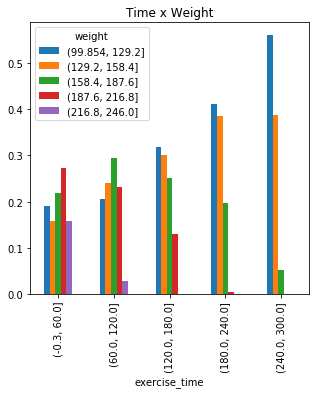

In [0]:
#Exercise_time by weight seems to have a great correlation.
t_by_w.plot.bar(title='Time x Weight', figsize=(5,5));


In [0]:
#Age may be confounding, how do we show this. Crosstab showing age groups and how they change the relationships

ct = pd.crosstab(time_bin, [age_bin, weight_bin])

ct

age             (17.938, 33.5]      ...         (64.5, 80.0]
weight         (99.854, 136.5]      ...       (209.5, 246.0]
exercise_time                       ...                     
(-0.3, 75.0]                18      ...                   31
(75.0, 150.0]               22      ...                    7
(150.0, 225.0]              35      ...                    0
(225.0, 300.0]              50      ...                    0

[4 rows x 16 columns]

In [0]:
import seaborn as sns

sns.pairplot(t_by_w)

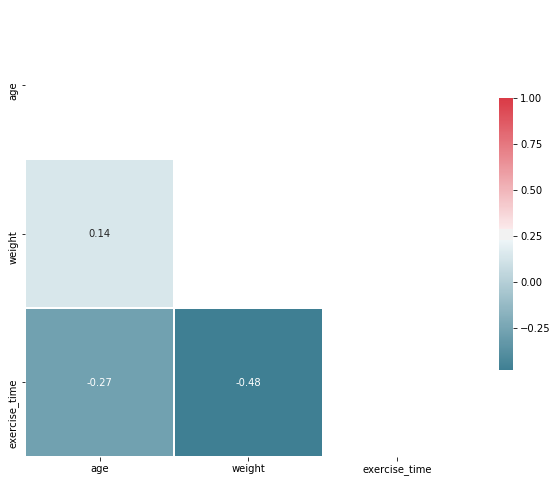

In [134]:
# THIS IS NOT MY CODE, taken from Harsh Desai

def correlation_heatmap(data=None, vmax=1, annot=True, corr_type='pearson'):
    if data is None:
        raise ValueError(
            "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    # Taken from the seaborn example at:
    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Compute the correlation matrix
    corr = data.corr(corr_type)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, axes = plt.subplots(figsize=(10, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vmax, annot=annot, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=axes)
    plt.show()
    plt.close()
    
correlation_heatmap(df)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

     All variables are ordinal and discrete

2.  What are the relationships between the variables?

    Time and Weight are negatively correlated.
    Age is a confounding variable that changes these correlations since some ages don't have certain times/weights and higher age has less counts for both time/weight.

3.  Which relationships are "real", and which spurious?

    Time and weight relationships are real. Age is spurious as the groups have different correlations because some ages don't exercise often.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)